In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
from dataclasses import dataclass
from matplotlib import rc
from matplotlib import colors
plt.style.use('seaborn')
# Settings for generating LaTeX figures
USE_TEX = True
PRODUCTION = True
if USE_TEX:
    sns.set(rc={'text.usetex': True})
    tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "axes.labelsize": 18,
        "font.size": 18,
        "legend.fontsize": 15,
        "xtick.labelsize": 15,
        "ytick.labelsize": 15
    }
    plt.rcParams.update(tex_fonts)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 500

In [2]:
@dataclass
class Cell:
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.2)
        self.curr_age = 1 if temp_age < 0 else temp_age
        self.carbon_mass = 0
        self.cs_rate = 0.025
    
    def set_cs_rate(self, density: float):
        pass
    
    def set_mass(self):
        pass
    
    def get_cs(self):
        return self.cs_rate
        
    def grow(self):
        self.curr_age += 1
        # if self.curr_age > self.max_age:
        #     self.cut()
        if self.carbon_mass + self.cs_rate < 3:
            self.carbon_mass += self.cs_rate
        
    def get_mass(self) -> float:
        return self.carbon_mass
    
    def cut(self) -> None:
        self.curr_age = 1
        self.set_mass()

def csr_mat(x):
    return (6.37*x) - (14.27*x**2) + (8.31*x**3)

class TropicalCell(Cell):
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.5 * self.max_age)
        self.curr_age = 1 if temp_age < 0 else temp_age
        self.flat_rate = 0
        
    def set_cs_rate(self, density: float):
        mat_dist = csr_mat( 0.5-((0.5-(self.curr_age/self.max_age)) / 1.1))
        mat = 0.4 - (0.4 - mat_dist)/3
        mu = (0.5 * np.pi *  40 * 43 / 2000)
        self.cs_rate = self.flat_rate + 0.5 *((mat * 0.5 * density) * np.random.normal(mu, 0.1 * mu))
    
    def set_mass(self):
        mu = (0.5 * np.pi * 40 * 43 / 2000) * (self.curr_age / self.max_age)
        self.carbon_mass = np.random.normal(mu, 0.1 * mu) 
        
class BorealCell(Cell):
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.5 * self.max_age)
        self.curr_age = 1 if temp_age < 0 else temp_age
        self.flat_rate = 0
        
    def set_cs_rate(self, density: float):
        mat_dist = csr_mat( 0.5-((0.5-(self.curr_age/self.max_age)) / 1.1))
        mat = 0.4 - (0.4 - mat_dist)/3
        mu = (0.5 * np.pi * (1.5**2) * 80 * 34 / 2000)
        self.cs_rate = self.flat_rate + 0.5 *(mat * 0.5 * density) * np.random.normal(mu, 0.1 * mu)
    
    def set_mass(self):
        mu = (0.5 * np.pi * (1.5**2) * 80 * 34 / 2000) * (self.curr_age / self.max_age)
        self.carbon_mass = np.random.normal(mu, 0.1 * mu) 
        
class TemperateCell(Cell):
    def __init__(self, max_age: int):
        self.max_age = max_age
        temp_age = np.random.normal(0.5 * self.max_age, 0.5 * self.max_age)
        self.curr_age = 1 if temp_age < 0 else temp_age
        self.flat_rate = 0.05
        
    def set_cs_rate(self, density: float):
        mat_dist = csr_mat( 0.5-((0.5-(self.curr_age/self.max_age)) / 1.1))
        mat = 0.4 - (0.4 - mat_dist)/3
        mu = (0.5 * np.pi * (1.25**2) * 60 * 41 / 2000)
        self.cs_rate = self.flat_rate + 0.5 * (mat * 0.5 * density) * np.random.normal(mu, 0.1 * mu)
    
    def set_mass(self):
        mu = (0.5 * np.pi * (1.2**2) * 60 * 41 / 2000) * (self.curr_age / self.max_age)
        self.carbon_mass = np.random.normal(mu, 0.1 * mu)

Creating forests given inputs

In [3]:
@dataclass
class Forest:
    def __init__(self, land, size: int, max_time: int, maturity: str, plotting: bool, phi: float, m: float, management_rate: int, begin_mgmt: int, ftype: str):
        self.size = size
        self.maturity = maturity
        self.plotting = plotting
        self.max_time = max_time
        self.land = land
        self.ftype = ftype
        self.management_rate = management_rate
        self.phi = phi #density threshold
        self.begin_mgmt = begin_mgmt
        self.m = m #mass threshold
        self.net_sequestration = []
        self.tot_atm_carbon = []
        self.rmvd_carbon = [] #carbon removed per deforestation
        self.tot_rmvd_carbon = [] # cumulative carbon removed
        self.curr_carbon = [] #carbon currently in forest
        self.total_carbon = [] #total carbon sequestration
        self.curr_atm_release = [] 
        
    def simulate(self) -> None:
        p = .55
        q = 1-p
        for t in range(self.max_time):
            if t == 0:
                for (ii, ij) in np.ndindex(self.land.shape):
                    self.land[ii, ij].set_mass()
            if t % 10 == 0:
                if self.plotting == True:
                    self.plot_2d_mass(time=t)
                    plt.title(r'$\mathrm{{Time}}={{{}}}$'.format(str(t)))
            if t % self.management_rate == 0 and t >= self.begin_mgmt:                  
                curr_rmv = self.deforest()
                self.rmvd_carbon.append(p * curr_rmv)
                self.tot_rmvd_carbon.append(sum(self.rmvd_carbon))
                if self.plotting == True:
                    self.plot_2d_mass(time=t)
                    plt.title(r'$\mathrm{{Harvest Time}}={{{}}}$'.format(str(t)))
            rand_order = np.random.permutation([(x, y) for x in range(self.size) for y in range(self.size)])
            for (ii, ij) in rand_order:
                assert(isinstance(self.land[ii, ij], Cell))
                density = self.land[ii, ij].get_mass() / self.get_surrounding_density(ii, ij)
                self.land[ii, ij].set_cs_rate(density)
                self.land[ii, ij].grow()
            self.curr_carbon.append(self.get_curr_carbon_mass())
        self.total_carbon = [v if i < self.begin_mgmt else v + self.tot_rmvd_carbon[math.floor((i-self.begin_mgmt)//self.management_rate)] \
                             for i, v in enumerate(self.curr_carbon)]
        self.total_atm_carbon = [0 if i < self.begin_mgmt else q * self.tot_rmvd_carbon[math.floor((i-self.begin_mgmt)//self.management_rate)] \
                                 for i, v in enumerate(self.curr_carbon)]
        self.net_sequestration = [x-y for x, y in zip(self.total_carbon, self.total_atm_carbon)]
        if self.plotting:
            fig, axes = plt.subplots(3,1, sharex=True, figsize=(6, 6))
            x = list(range(1, self.max_time + 1))
            sns.set_style(style = "whitegrid") 
            sns.lineplot(x=x, y=self.total_carbon, color='#81A1C1')
            sns.lineplot(ax = axes[1], x=x, y=self.total_atm_carbon, color='#81A1C1')
            sns.lineplot(ax = axes[2], x=x, y=self.net_sequestration, color='#81A1C1')
            if USE_TEX:
                plt.xlabel(r'Time (yr)')
                plt.ylabel(r"Total Carbon Sequestered (tC)")
                axes[0].set(ylabel=r"$\mathrm{Total\ Carbon\ Sequestered \ (tC)}$")
                axes[1].set(ylabel=r"$\mathrm{Total\ Carbon\ Lost\ to\ Atmosphere\ (tC)}$")
                axes[2].set(ylabel=r"$\mathrm{Net\ Carbon\ Sequestration \ (tC)}$")
            axes[0].yaxis.get_label().set_fontsize(7)
            axes[1].yaxis.get_label().set_fontsize(7)
            axes[2].yaxis.get_label().set_fontsize(7)
            plt.suptitle('Carbon Levels Over Time',fontsize=15)
            fig.align_ylabels()
            plt.tight_layout(pad=2.0)
            if PRODUCTION:
                path = "./better_images/" + self.ftype + "_" + str(self.phi) + "_" + str(self.management_rate)
                plt.savefig(path + ".pdf")
                with open(path+'.txt', 'w') as f:
                    f.writelines(["Total Carbon Sequestration: " + str(self.total_carbon[-1]) + "\n", \
                                 "Total Carbon Lost to Atmosphere: " + str(self.total_atm_carbon[-1]) + "\n", \
                                 "Net Sequestration: " + str(self.total_carbon[-1] - self.total_atm_carbon[-1])])
        else:
            return self.total_carbon, self.total_atm_carbon, self.net_sequestration
        
    def deforest(self) -> int:
        curr_rmvd = 0
        rand_order = np.random.permutation([(x, y) for x in range(2,self.size - 2) for y in range(2,self.size - 2)])
        for (ii, ij) in rand_order:
            surr_mass = self.get_surrounding_density(ii, ij) * 8
            if surr_mass > self.phi: 
                for (ix, iy) in [(x, y) for x in range(ii - 1, ii + 2) for y in range(ij - 1, ij + 2)]:
                    curr_mass = self.land[ix, iy].get_mass()
                    if curr_mass > self.m:
                        rand = np.random.random()
                        if rand > .9:
                            self.land[ix, iy].cut()
                            curr_rmvd += curr_mass
        return curr_rmvd
        
    def get_surrounding_density(self, ii: int, ij: int) -> float:
        if ii == 0: 
            if ij == 0: #upper left corner
                return (self.land[ii + 1, ij].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii + 1, ij + 1].get_mass()) / 3
            elif ij == self.size - 1: #upper right corner
                return (self.land[ii + 1, ij].get_mass() + self.land[ii, ij - 1].get_mass() \
                       + self.land[ii + 1, ij - 1].get_mass()) / 3
            else: #first row
                return (self.land[ii, ij - 1].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii + 1, ij - 1].get_mass() + self.land[ii + 1, ij].get_mass() \
                       + self.land[ii + 1, ij + 1].get_mass()) / 5
        elif ii == self.size - 1:
            if ij == 0: #lower left corner
                return (self.land[ii - 1, ij].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii - 1, ij - 1].get_mass()) / 3
            elif ij == self.size - 1: #lower right corner
                return (self.land[ii - 1, ij - 1].get_mass() + self.land[ii - 1, ij].get_mass() \
                       + self.land[ii, ij - 1].get_mass()) / 3
            else: #last row
                return (self.land[ii, ij - 1].get_mass() + self.land[ii, ij + 1].get_mass() \
                       + self.land[ii - 1, ij - 1].get_mass() + self.land[ii - 1, ij].get_mass() \
                       + self.land[ii - 1, ij + 1].get_mass()) / 5
        elif ij == 0: #first column
            return (self.land[ii - 1, ij].get_mass() + self.land[ii - 1, ij + 1].get_mass() \
                   + self.land[ii, ij + 1].get_mass() + self.land[ii + 1, ij].get_mass() \
                   + self.land[ii + 1, ij + 1].get_mass()) / 5
        elif ij == self.size - 1: #last column
            return (self.land[ii - 1, ij].get_mass() + self.land[ii - 1, ij - 1].get_mass() \
                   + self.land[ii, ij - 1].get_mass() + self.land[ii + 1, ij].get_mass() \
                   + self.land[ii + 1, ij - 1].get_mass()) / 5
        else: #middle cells
            return (self.land[ii - 1, ij - 1].get_mass() + self.land[ii - 1, ij].get_mass() \
                   + self.land[ii - 1, ij + 1].get_mass() + self.land[ii, ij - 1].get_mass() \
                   + self.land[ii, ij + 1].get_mass() + self.land[ii + 1, ij - 1].get_mass() \
                   + self.land[ii + 1, ij].get_mass() + self.land[ii + 1, ij + 1].get_mass()) / 8
                
    def get_curr_carbon_mass(self) -> int:
        return sum([self.land[ii, ij].get_mass() for (ii, ij) in np.ndindex(self.land.shape)])
    
    def plot_carbon(self, pl="TCS") -> None:
        self.simulate()
        fig, axes = plt.subplots(1, 2)
        curr_state = self.populate_state()
        sns.heatmap(curr_state, cmap="YlGnBu", ax=axes[0])
        x = list(range(1, self.max_time + 1))
        sns.set_style(style = 'whitegrid') 
        if pl == "TCS":
            sns.lineplot(ax = axes[1], x=x, y=self.total_carbon, color='#81A1C1')
            axes[1].set(xlabel='Time', ylabel='Total Carbon Sequestered')
        elif pl == "rmvd":
            x = list(range(1, self.max_time + 1, 10))
            axes[1] = sns.lineplot(x=x, y=self.rmvd_carbon, color='#81A1C1')
            axes[1].set(xlabel='Time', ylabel='Carbon Removed per Deforestation')
        elif pl == "tot_rmvd":
            x = list(range(1, self.max_time + 1, 10))
            axes[1] = sns.lineplot(x=x, y=self.tot_rmvd_carbon, color='#81A1C1')
            axes[1].set(xlabel='Time', ylabel='Total Carbon Removed')
        elif pl == "curr":
            axes[1] = sns.lineplot(x=x, y=self.curr_carbon, color='#81A1C1')
            axes[1].set(xlabel='Time', ylabel='Current Carbon Content')
        plt.xlim(0)
        plt.ylim(0)
        plt.show()
        print(self.total_carbon[-1])
    
    def populate_state(self):
        ret = [[0 for _ in range(self.size)] for _ in range(self.size)]
        for i in range(self.size):
            for j in range(self.size):
                ret[i][j] = self.land[i, j].get_mass()   
        return ret
        
    def plot_2d_mass(self, time=0) -> None:
        curr_state = self.populate_state()
        ax = sns.heatmap(curr_state, cmap =sns.cubehelix_palette(start=2, rot=0, dark=0.2, light=.8,as_cmap=True),\
                         vmin = 0, vmax = 3, xticklabels=False, yticklabels=False, cbar_kws={'label': '$\mathrm{Carbon\ Mass\ (tC)}$'})
        plt.savefig("./tropical_landscape/" + self.ftype + "_" + str(time) + ".png")
        plt.show()
        
class Tropical(Forest):
    def __init__(self, size: int,max_time: int, maturity: str, plotting: bool, phi: float, m: float, management_rate: int, begin_mgmt: int, ftype="tropical"):
        super().__init__(np.array([[TropicalCell(np.random.normal(95, 15)) for _ in range(size)] for _ in range(size)]), \
                         size, max_time, maturity, plotting, phi, m, management_rate, begin_mgmt, ftype="tropical")
class Boreal(Forest):
    def __init__(self, size: int,max_time: int, maturity: str, plotting: bool, phi: float, m: float, management_rate: int, begin_mgmt: int, ftype="boreal"):
        super().__init__(np.array([[BorealCell(np.random.normal(150, 25)) for _ in range(size)] for _ in range(size)]), \
                         size, max_time, maturity, plotting, phi, m, management_rate, begin_mgmt, ftype="boreal")
        
class Temperate(Forest):
    def __init__(self, size: int,max_time: int, maturity: str, plotting: bool, phi: float, m: float, management_rate: int, begin_mgmt: int, ftype="temperate"):
        super().__init__(np.array([[BorealCell(np.random.normal(110, 20)) for _ in range(size)] for _ in range(size)]), \
                         size, max_time, maturity, plotting, phi, m, management_rate, begin_mgmt, ftype="temperate")

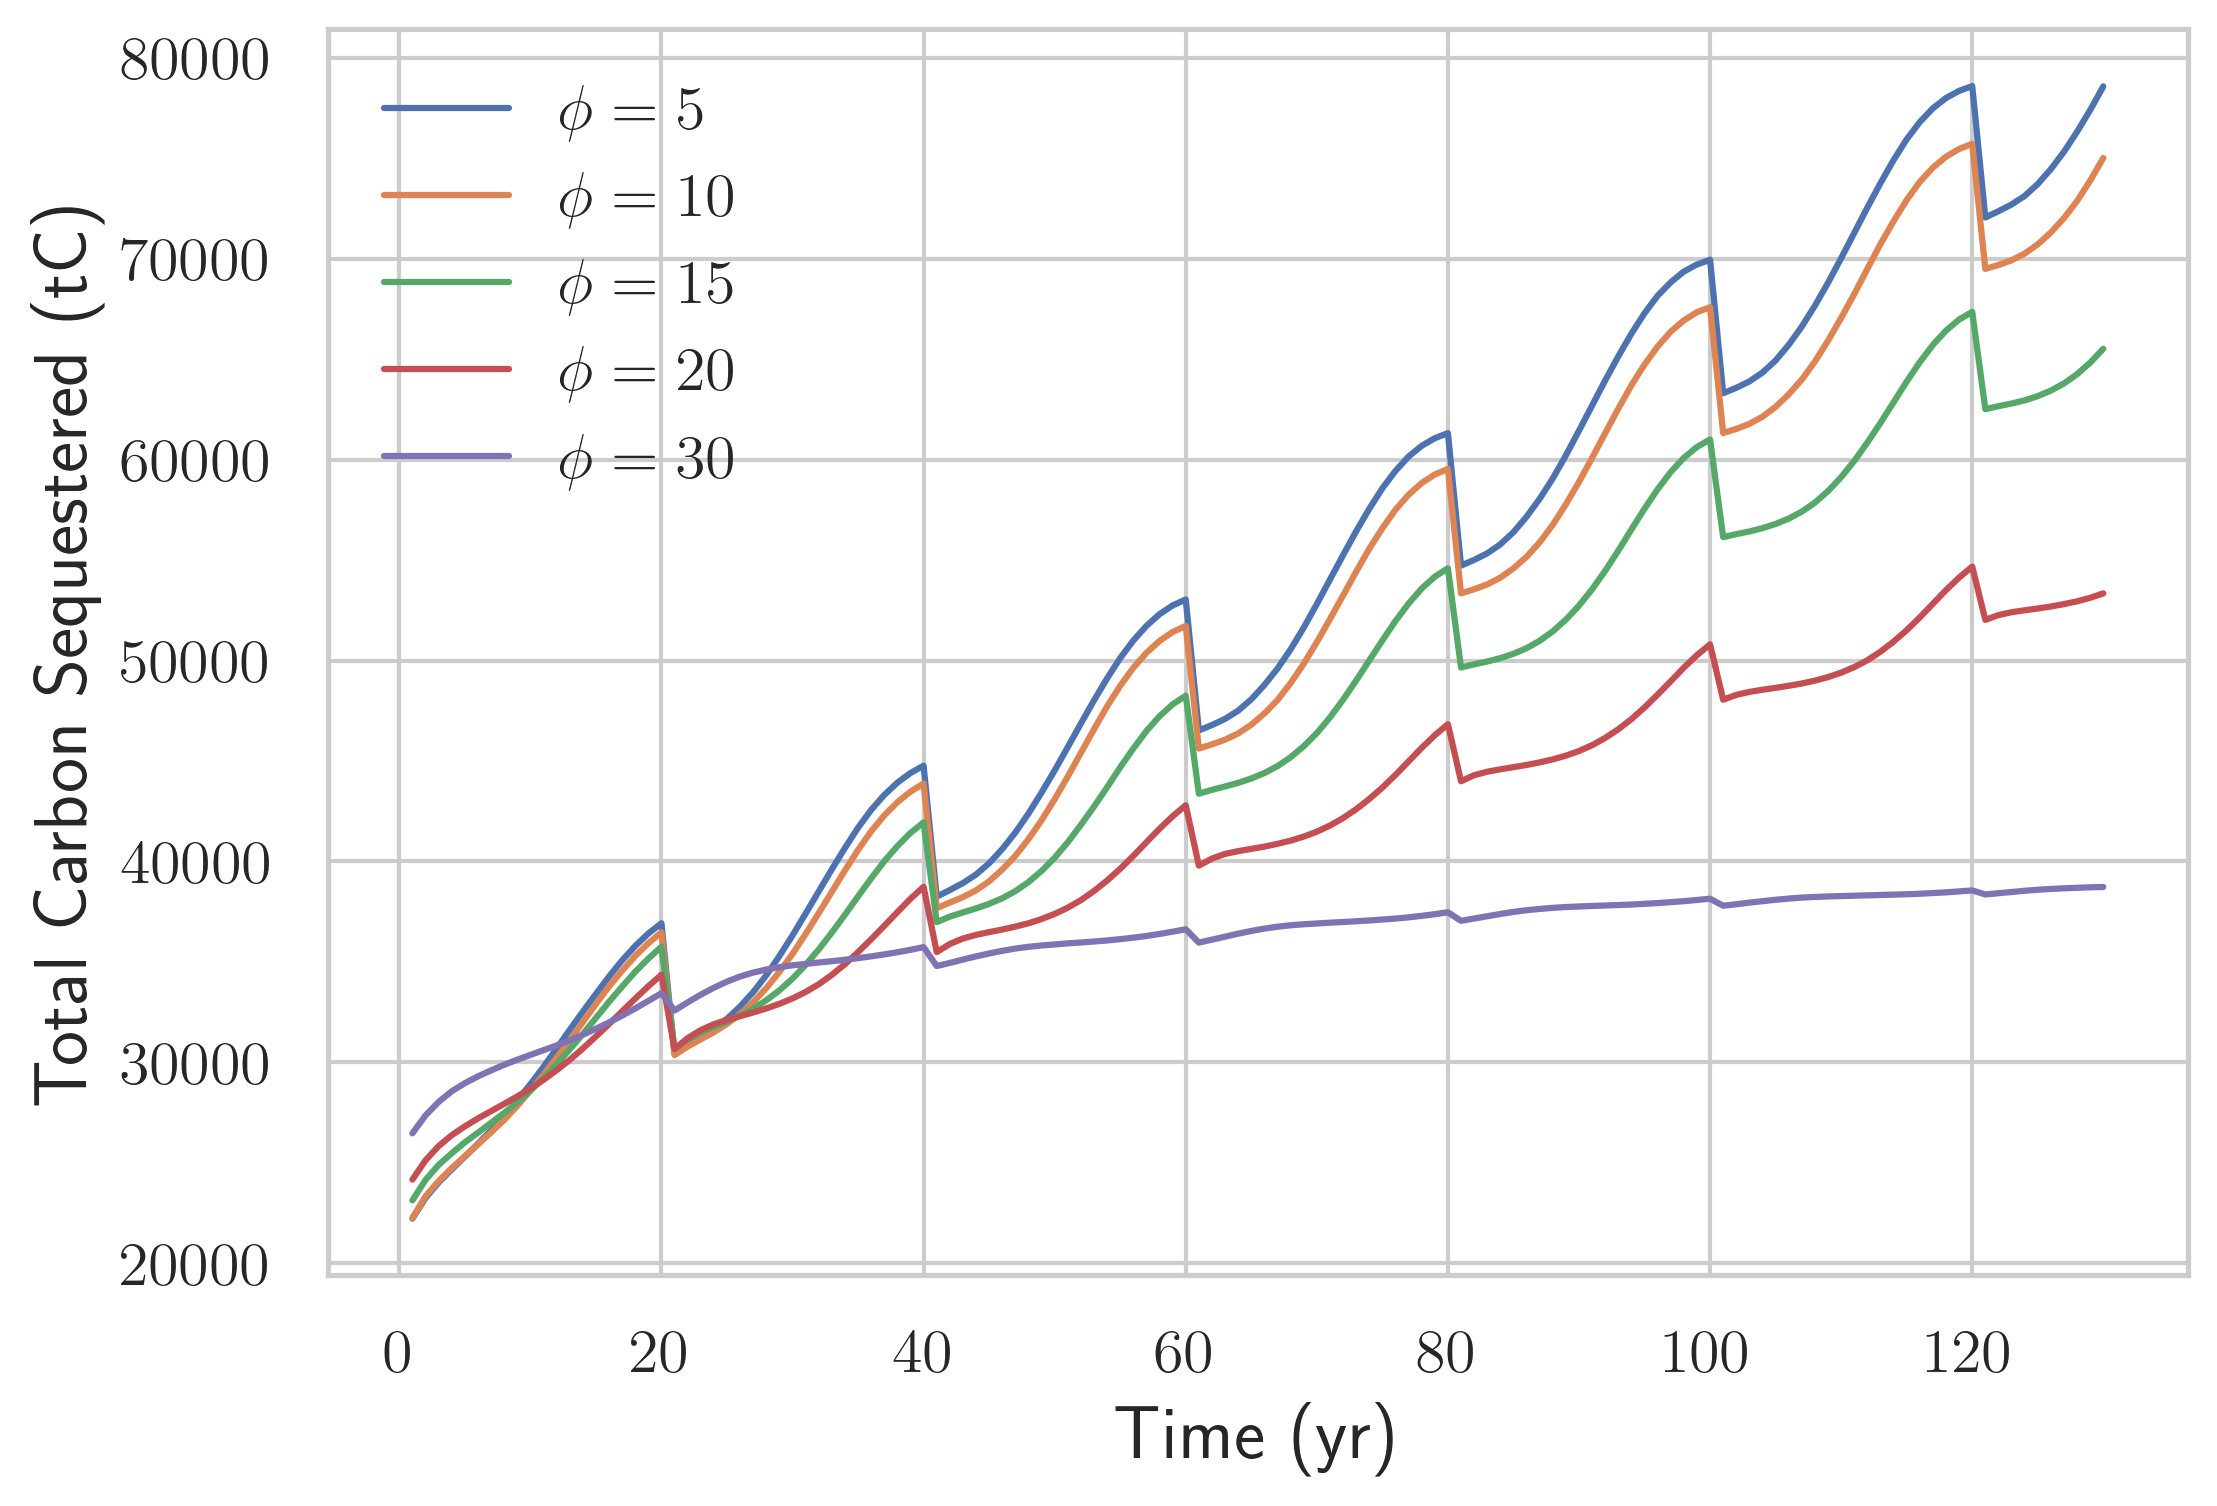

In [46]:
phi_VALS = [5, 10, 15, 20, 30]
ov_total_carbon = [] 
ov_total_atm_carbon = [] 
ov_net_sequestration = []
for i in phi_VALS:
    tropical = Temperate(100, 130, "test", False, i, 2.3, 20, 0, ftype="Tropical")
    vals = tropical.simulate()
    ov_total_carbon.append(vals[0])
    ov_total_atm_carbon.append(vals[1])
    ov_net_sequestration.append(vals[2])

def plot_total_carbon(pl="tot_carbon"):
    x = list(range(1, 130 + 1))
    sns.set_style(style = "whitegrid") 
    fig, ax = plt.subplots(sharex=True)
    y = ov_total_carbon if pl == "tot_carbon" else ov_total_atm_carbon if pl == "tot_atm" \
        else ov_net_sequestration
    for i in range(len(phi_VALS)):
        plt.plot(x, y[i], label=r'$\phi = {}$'.format(str(phi_VALS[i])))
    plt.legend()
    plt.xlabel(r'Time (yr)')
    plt.ylabel(r"Total Carbon Sequestered (tC)" if pl == "tot_carbon" else \
               r'Total Carbon Lost to Atmosphere (tC)' \
               if pl == "tot_atm" else r'Net Carbon Sequestration (tC)')
    plt.savefig("better_images/" + "temperate" + pl + "_temp.pdf")

plot_total_carbon()

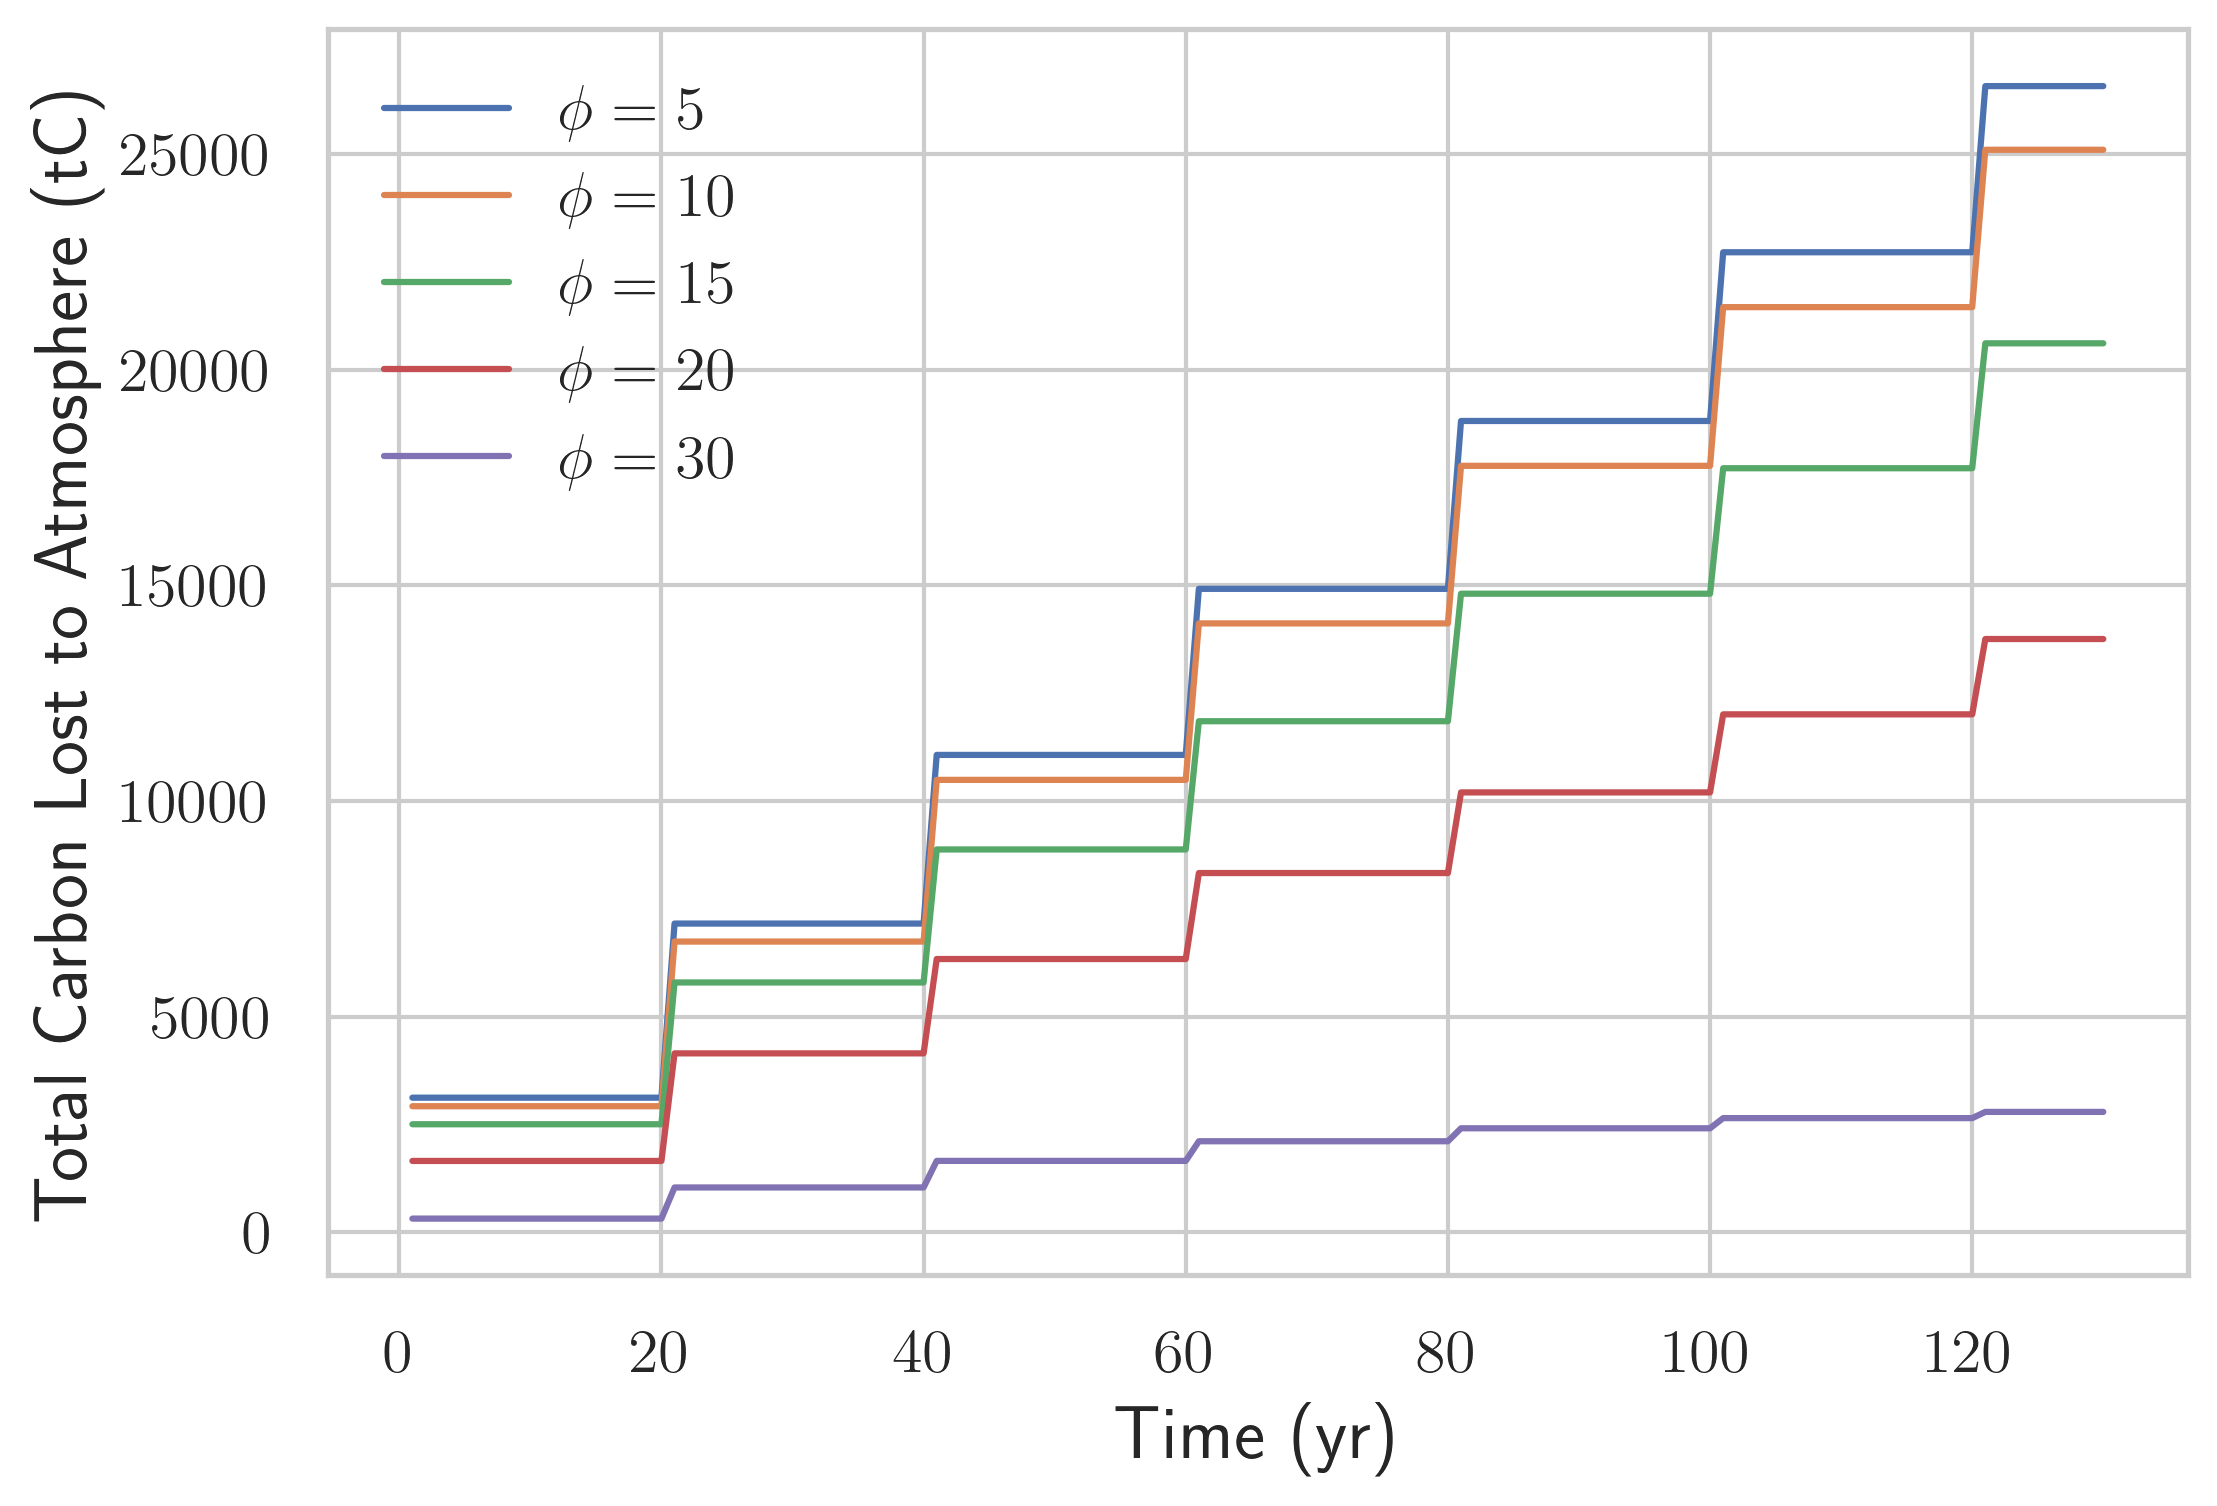

In [47]:
plot_total_carbon("tot_atm")

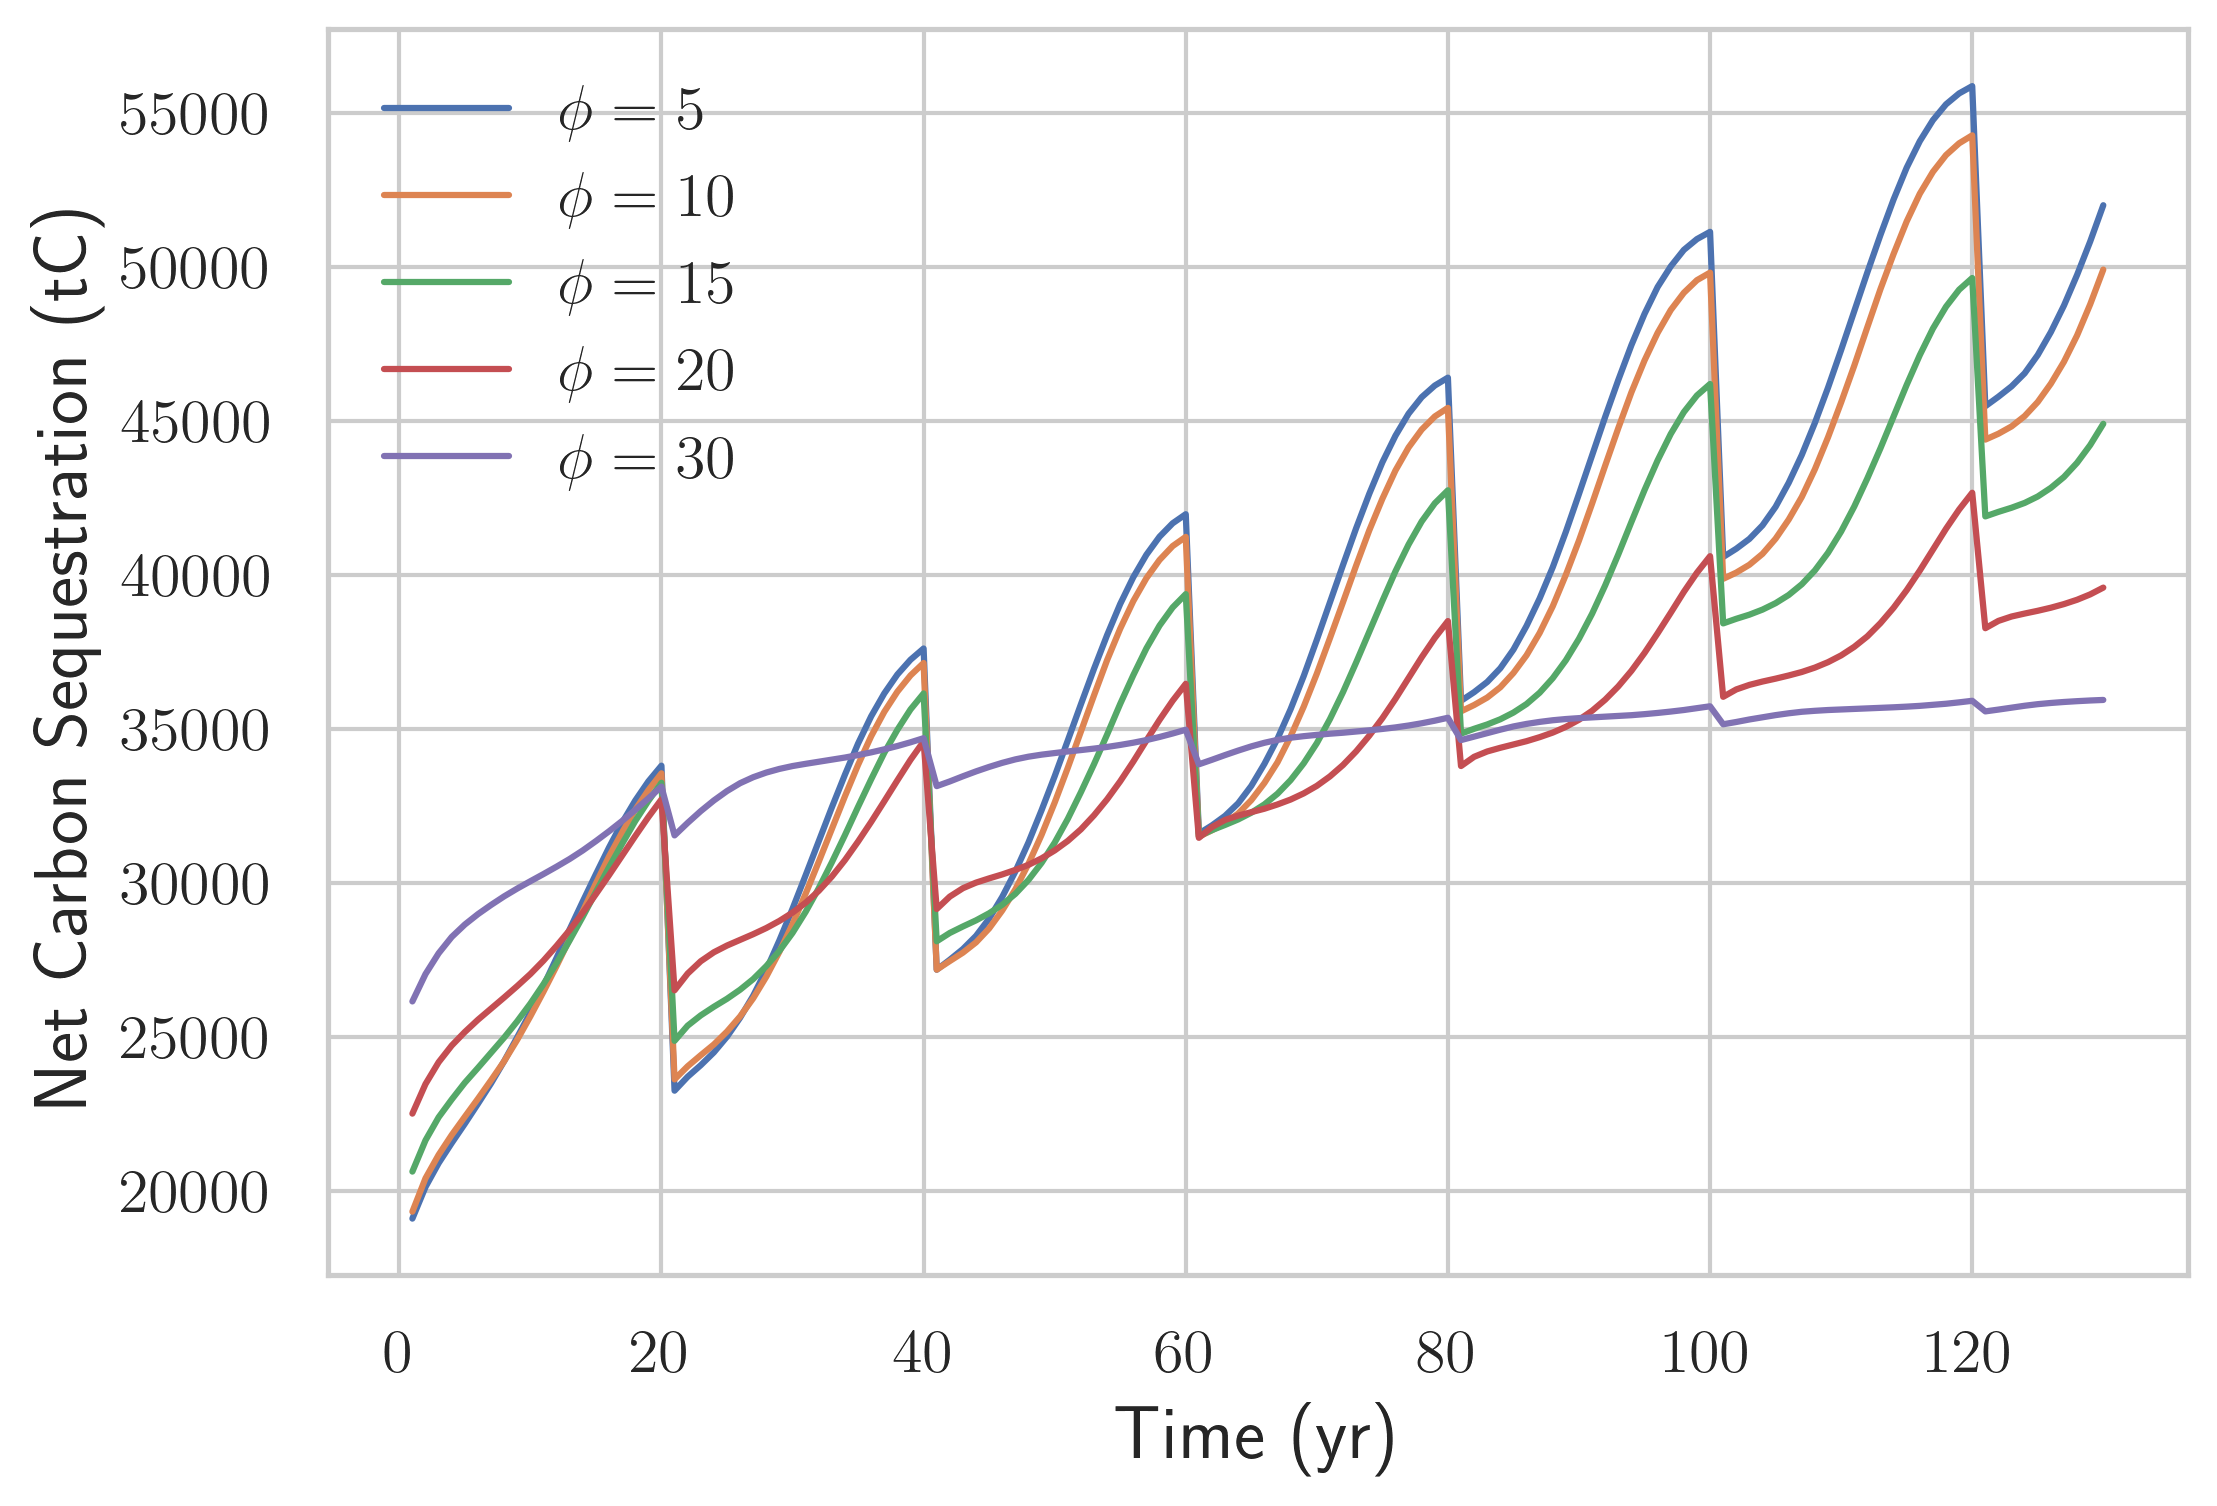

In [48]:
plot_total_carbon("net_seq")

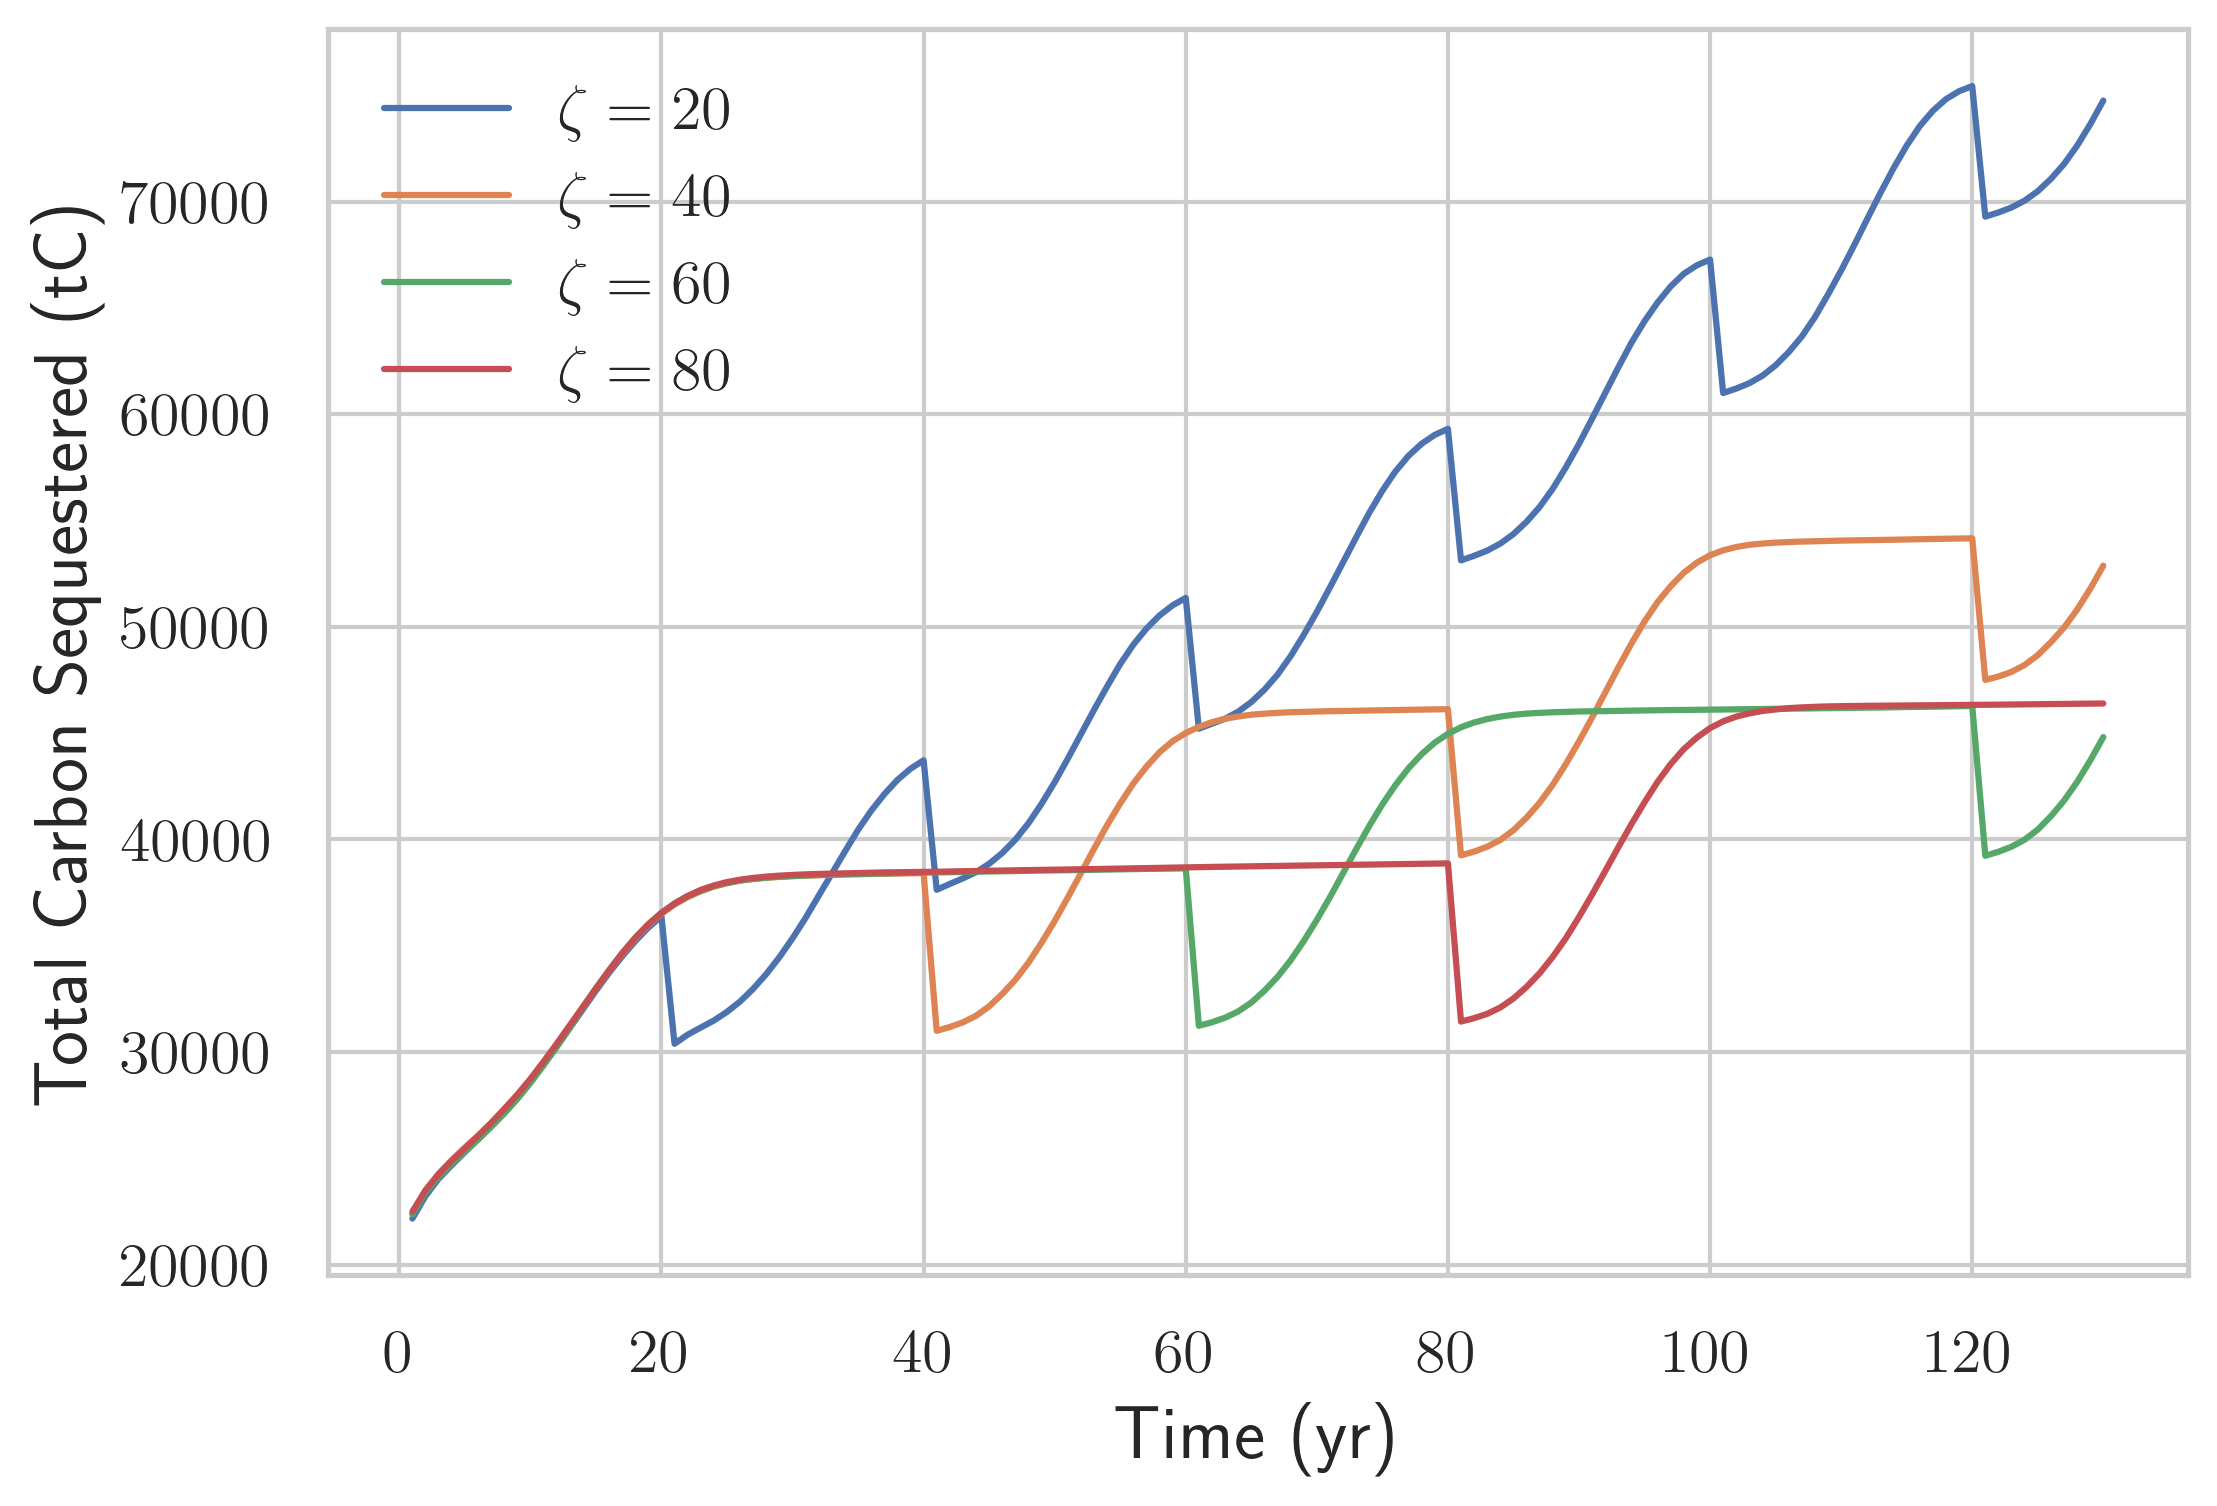

In [49]:
MGM_VALS = [20,40,60,80]
ov_total_carbon = [] 
ov_total_atm_carbon = [] 
ov_net_sequestration = []
for i in MGM_VALS:
    tropical = Temperate(100, 130, "test", False, 10, 2.3, i, 0, ftype="Tropical")
    vals = tropical.simulate()
    ov_total_carbon.append(vals[0])
    ov_total_atm_carbon.append(vals[1])
    ov_net_sequestration.append(vals[2])

def plot_total_carbon_mgm(pl="tot_carbon"):
    x = list(range(1, 130 + 1))
    sns.set_style(style = "whitegrid") 
    fig, ax = plt.subplots(sharex=True)
    y = ov_total_carbon if pl == "tot_carbon" else ov_total_atm_carbon if pl == "tot_atm" \
        else ov_net_sequestration
    for i in range(len(MGM_VALS)):
        plt.plot(x, y[i], label=r'$\zeta = {}$'.format(str(MGM_VALS[i])))
    plt.legend()
    plt.xlabel(r'Time (yr)')
    plt.ylabel(r"Total Carbon Sequestered (tC)" if pl == "tot_carbon" else \
               r'Total Carbon Lost to Atmosphere (tC)' \
               if pl == "tot_atm" else r'Net Carbon Sequestration (tC)')
    plt.savefig("better_images/" + "temperate" + pl + ".pdf" )

plot_total_carbon_mgm()

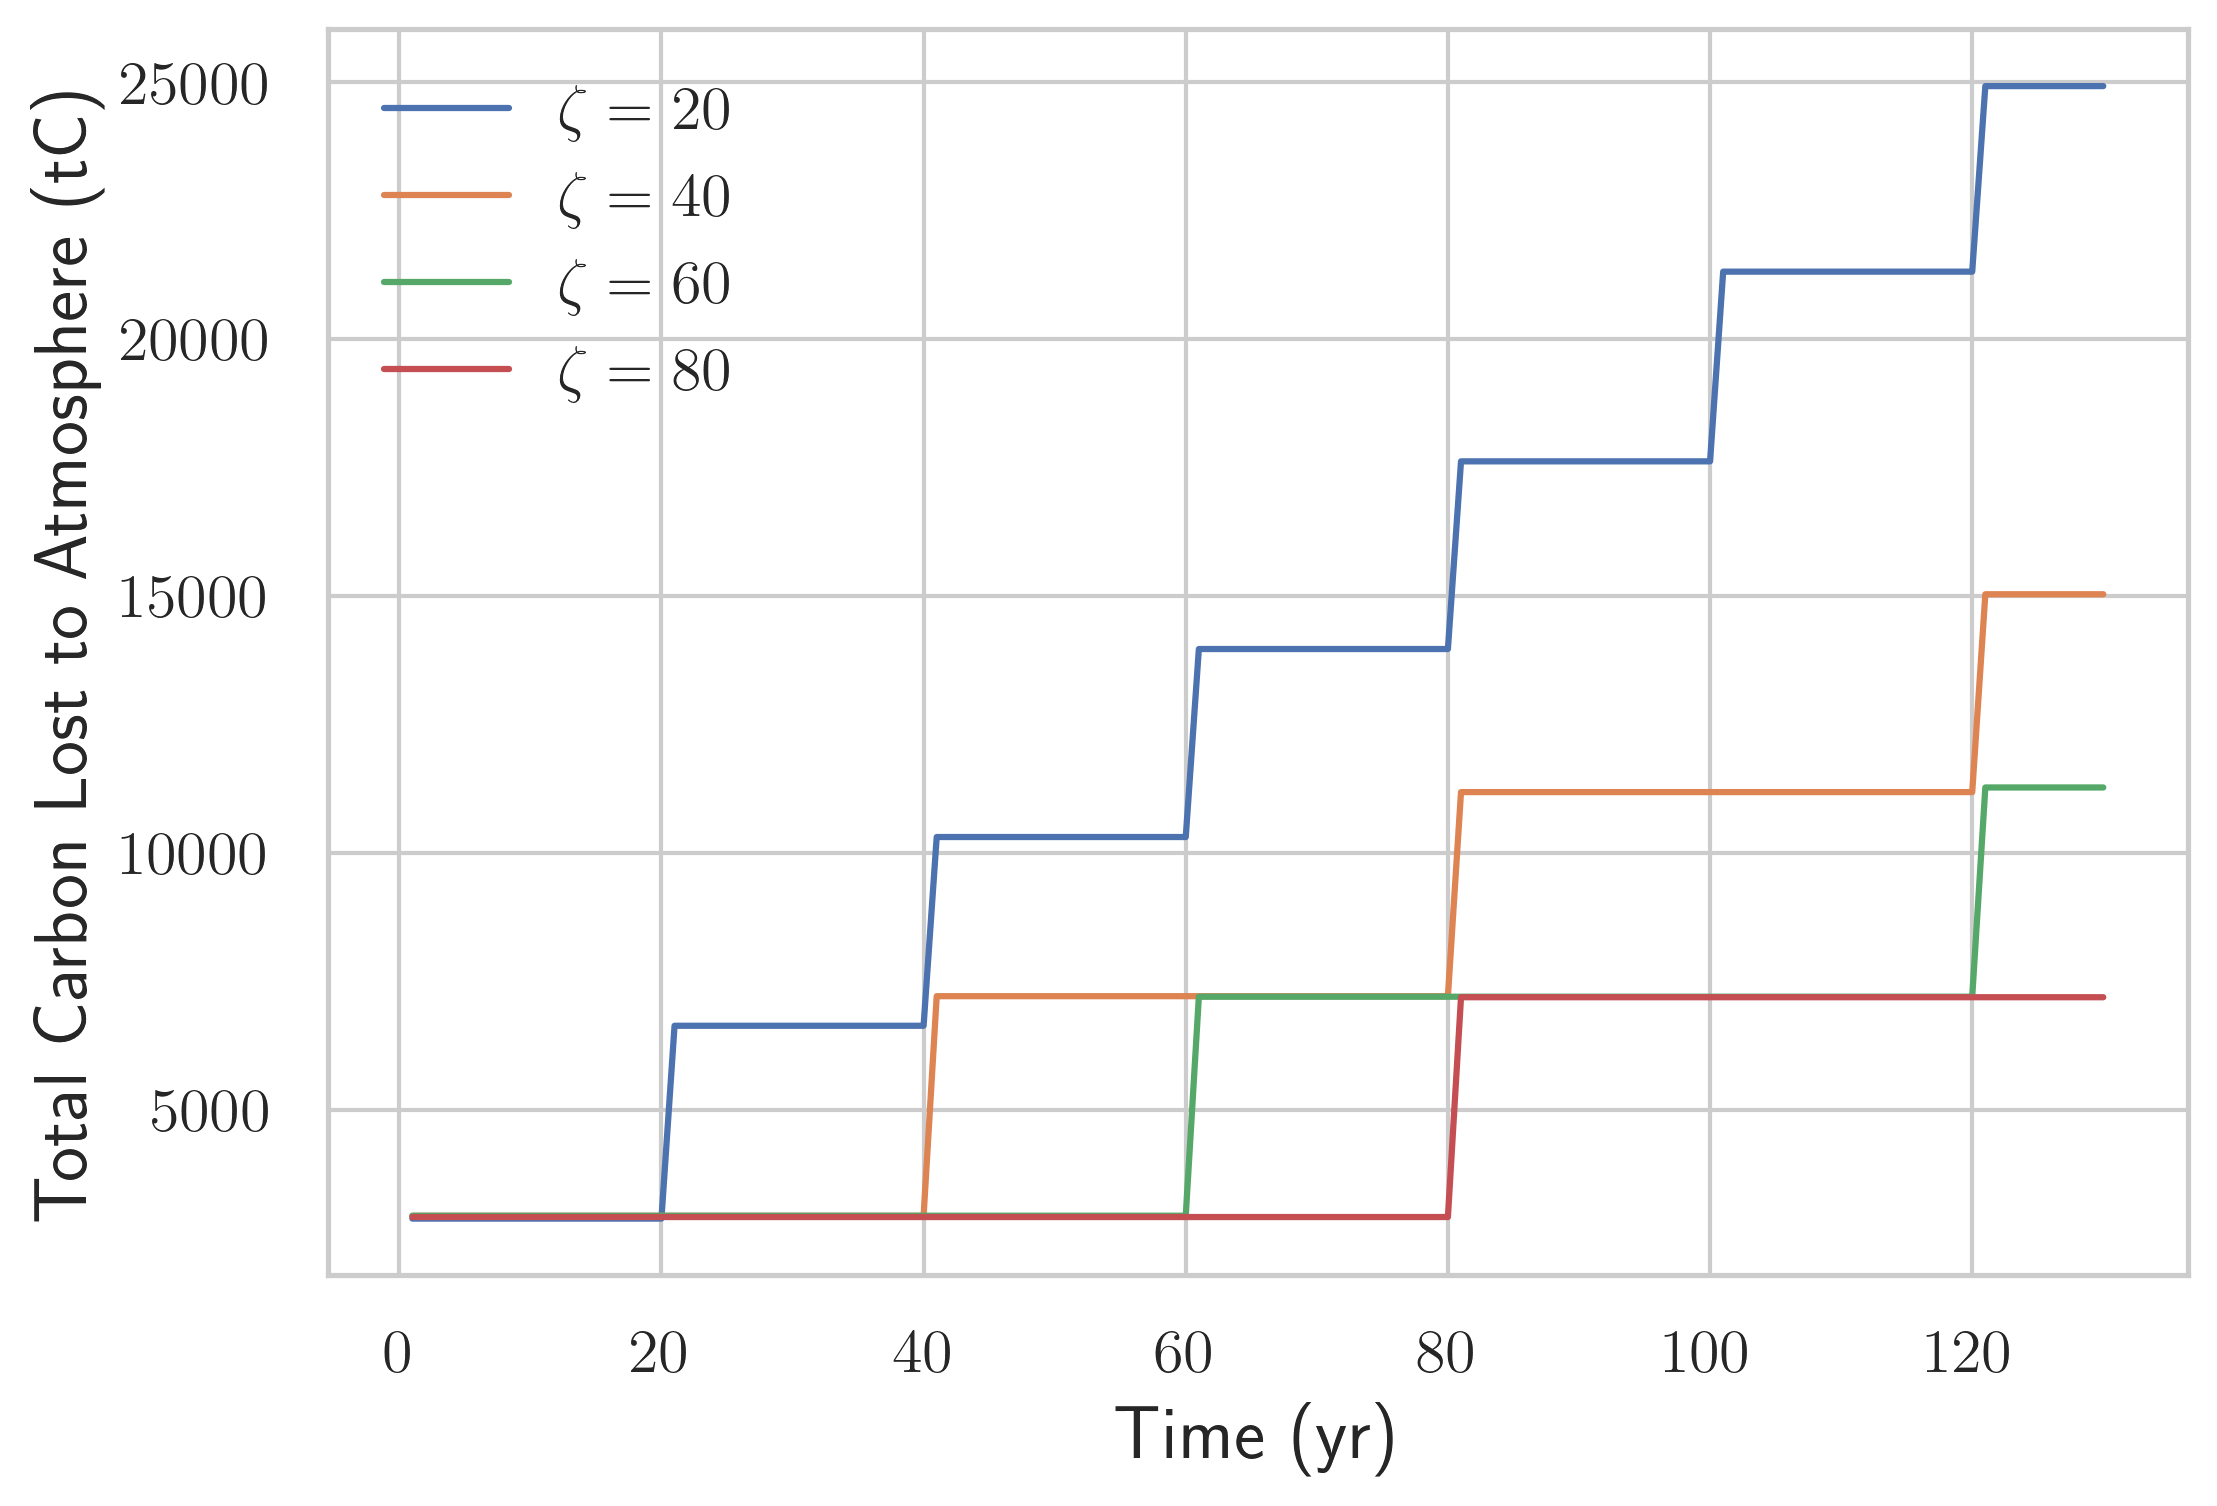

In [50]:
plot_total_carbon_mgm("tot_atm")

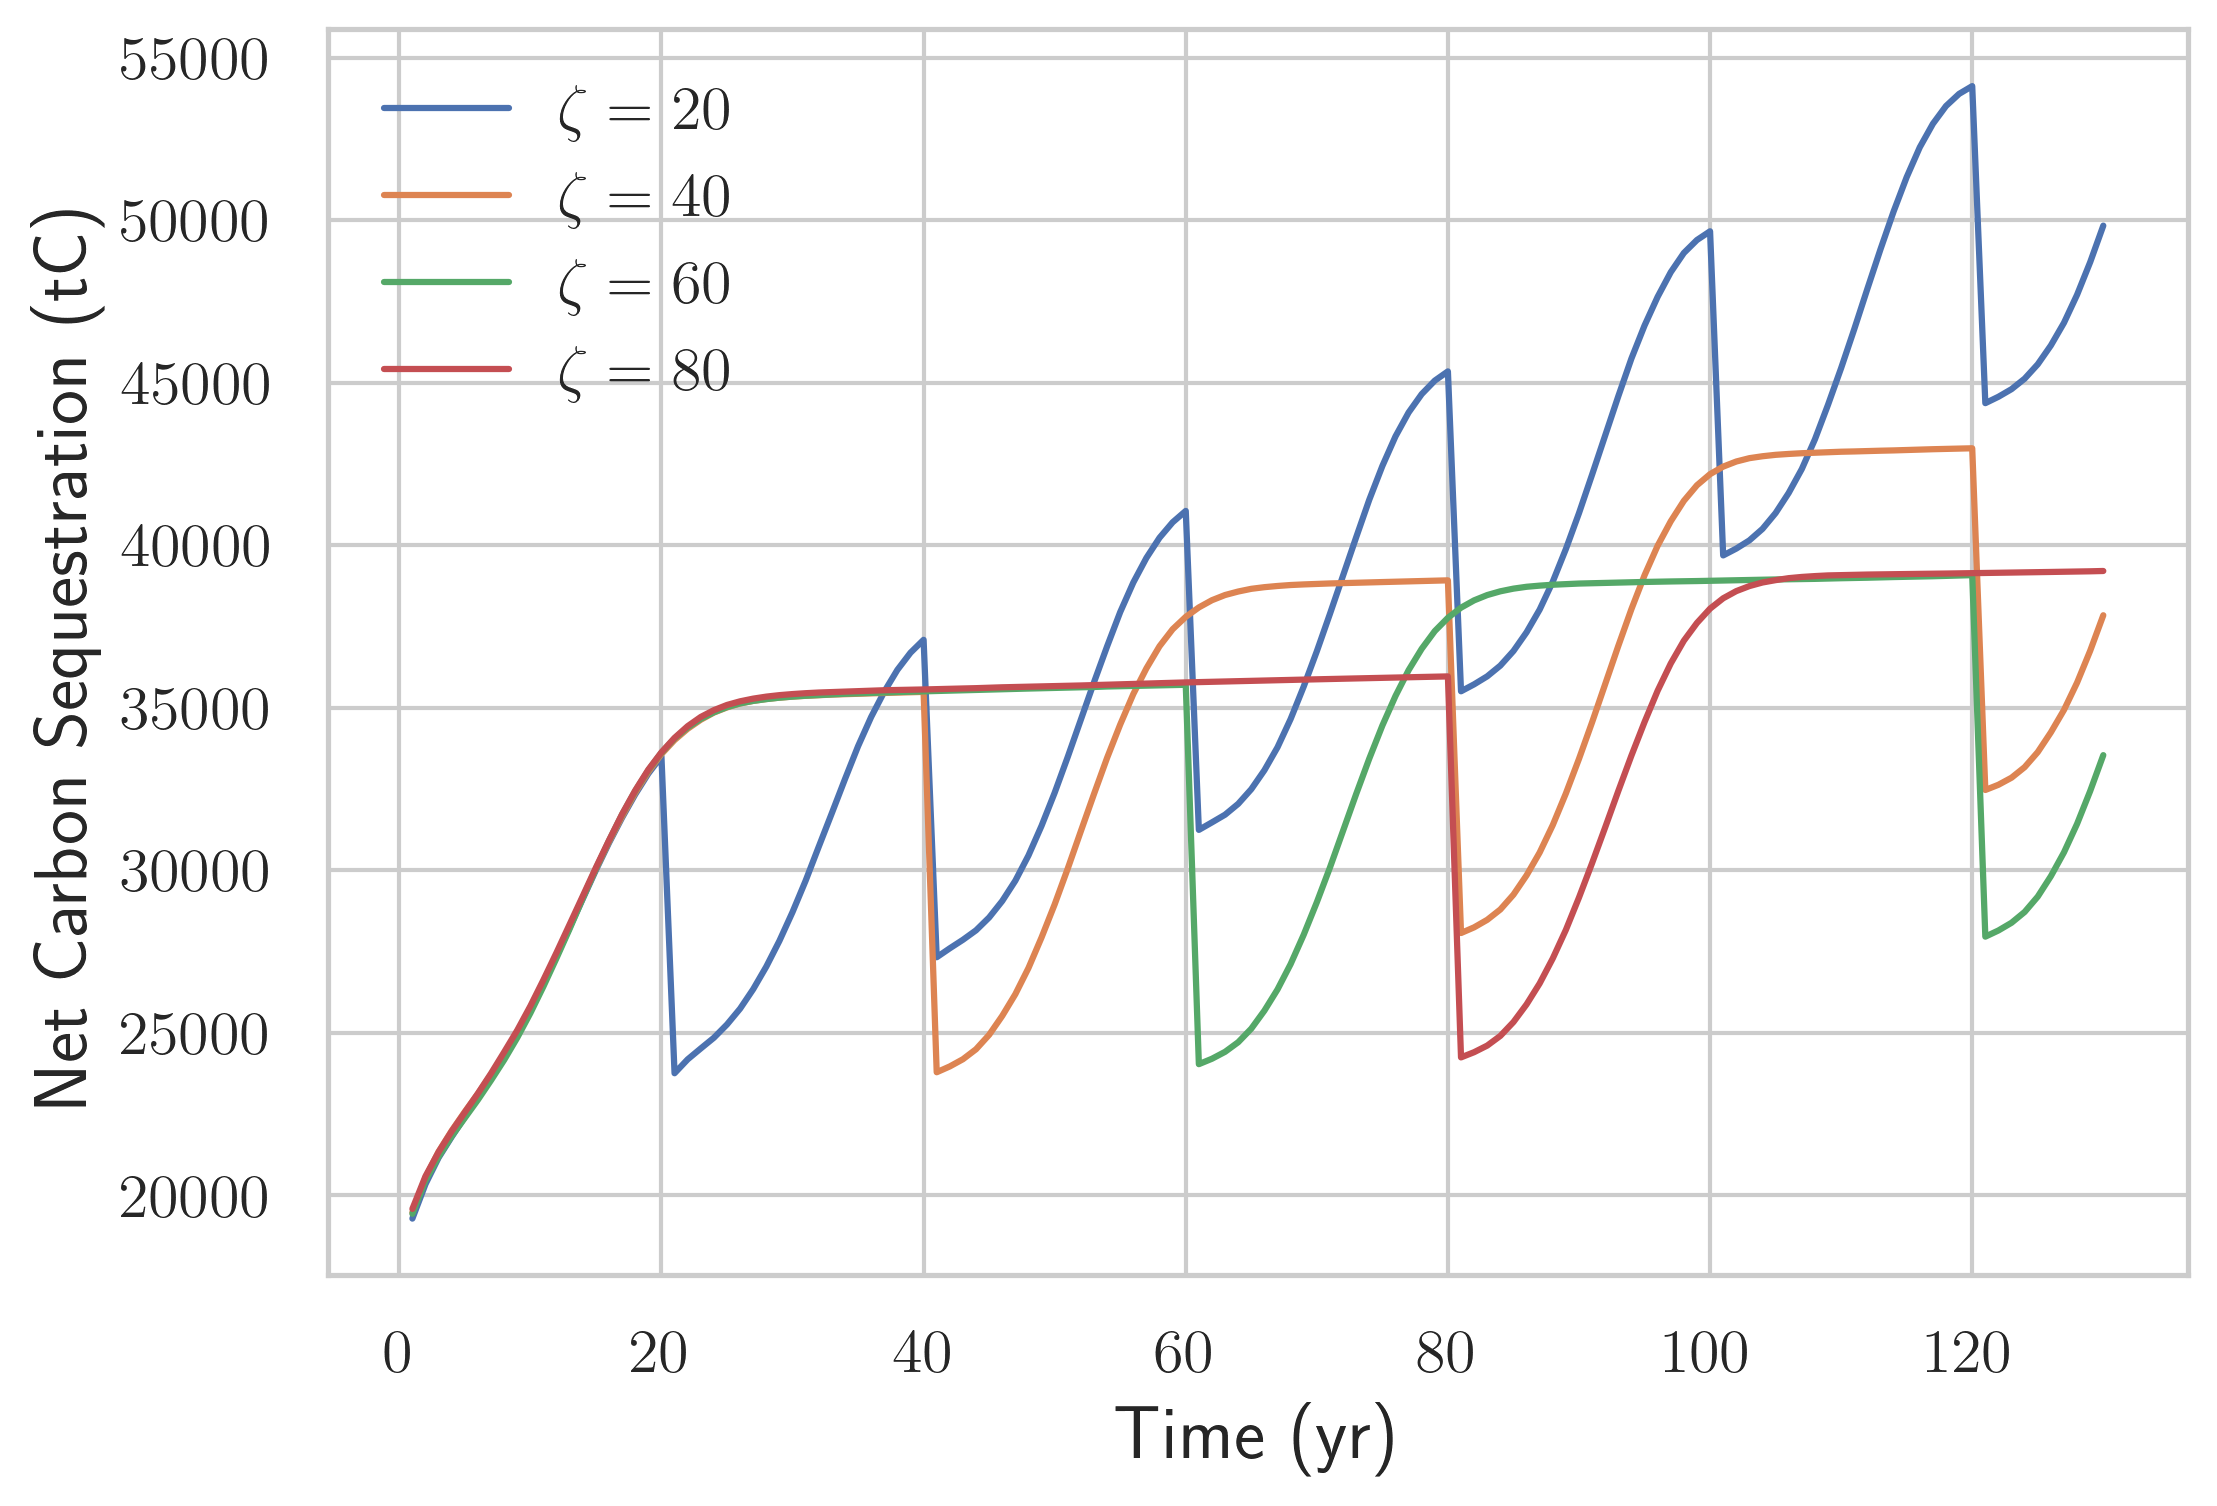

In [51]:
plot_total_carbon_mgm("net_seq")

In [ ]:
boreal = Boreal(100, 130, "test", True, 100, 2.3, 20, 0, ftype="Boreal")
boreal.simulate()

In [ ]:
temperate = Temperate(100, 130, "test", True, 100, 2.3, 20, ftype="Temperate")
temperate.simulate()

In [ ]:
tropical = Tropical(100, 130, "test", True, 100, 2.3, 20, 0, ftype="Tropical")
tropical.simulate()